# Lower speed camera ticketing threshold: cash grab or effective safety policy?

In [1]:
#import packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import seaborn as sns
from IPython.display import Image

Speed cameras have been a part of Chicago streets since August 2013, and by 2019 there were 161 speed cameras in operation spread across the city. The debate on the efficacy of speed cameras has long been debated with an [extensive report from UIC](https://uofi.app.box.com/s/xz94sfxhstivi1r0pu0rzl11mfm3s3oh) published on January 2022.

On March 1st 2021, Mayor Lori Lightfoot lowered the threshold for speeding tickets from 10 mph over the limit to 6 mph. This policy is primarily enforced by the 162 speed cameras currently set up around Chicago. 

My motivation for performing this analysis is driven by the fact that my household received 3 separate speeding tickets when the policy was enacted. So I want to know whether this policy is effective at lowering the amount of serious accidents in Chicago?

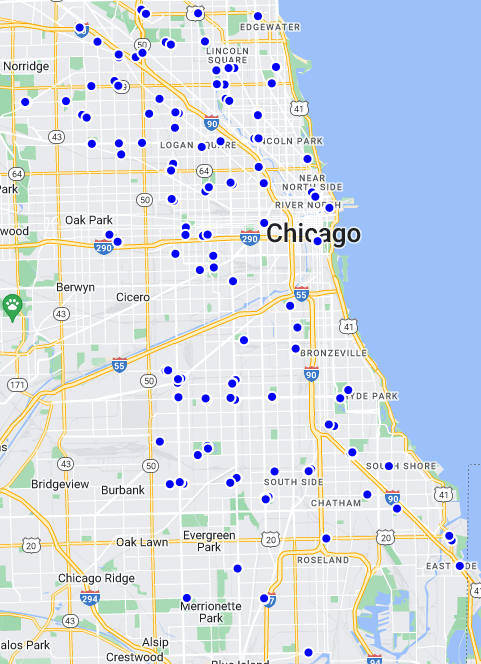

In [2]:
Image(filename="Chicago_Speed_Camera_Locations.png")

### Data Load

In [3]:
crash = pd.read_csv('Traffic_Crashes_Crashes.csv')
violations = pd.read_csv('Speed_Camera_Violations.csv')
cameras = pd.read_csv('Speed_Camera_Locations.csv')

### Data Cleaning

In [4]:
#Formating camera address to be grouped by their respective Chicago city block
cameras['ADDRESS'] = [re.sub("\(Speed Camera\)","",addr).strip().upper() for addr in cameras['ADDRESS']]
cameras['STREET_NO'] = [re.findall("\d+",street_no)[0] for street_no in cameras['ADDRESS']]
cameras['BLOCK_NO'] = round(cameras['STREET_NO'].astype(int)/100)*100
cameras = cameras.astype({"BLOCK_NO":int})
cameras['FULL_ADDR'] = [re.sub(street_no,block_no,address) for street_no, block_no, address 
                        in zip(cameras['STREET_NO'],cameras['BLOCK_NO'].astype(str),cameras['ADDRESS'])]

In [5]:
#Remove crashes without reported streets
crash.dropna(subset=["STREET_NAME"],inplace=True)

#Formatting location of crash address to be grouped by their respective Chicago city block
crash['STREET_NO'] = crash['STREET_NO'].astype({"STREET_NO":int})
crash['BLOCK_NO'] = round(crash['STREET_NO']/100)*100
crash = crash.astype({"BLOCK_NO":int})
crash['FULL_ADDR'] = crash['BLOCK_NO'].astype(str) +" "+ crash['STREET_DIRECTION'] +" "+ crash['STREET_NAME'] 

#Format date and adding a column to allow for date to be grouped by month
crash['CRASH_DATE'] = pd.to_datetime(crash['CRASH_DATE'],format="%m/%d/%Y %I:%M:%S %p").dt.date
crash['CRASH_DATE_MONTH'] = [dt.replace(day=1) for dt in crash['CRASH_DATE']]

violations['VIOLATION DATE'] = pd.to_datetime(violations['VIOLATION DATE'],format="%m/%d/%Y").dt.date
violations['VIOLATION DATE TRUNC'] = [dt.replace(day=1) for dt in violations['VIOLATION DATE']]

In [6]:
#Dropping crashes that occurred prior to 9/1/17 because entire city did not start reporting on crashes until this date.
crash = crash[(crash['CRASH_DATE_MONTH']>datetime(2017,9,1).date())&(crash['CRASH_DATE_MONTH']<datetime(2023,8,1).date())]
violations = violations[(violations['VIOLATION DATE']>datetime(2017,9,1).date())&(violations['VIOLATION DATE']<datetime(2023,1,1).date())]

In [7]:
#speed camera block location plus adjacent blocks.
cameras['BLOCK_NO_UP'] = cameras['BLOCK_NO'] +100
cameras['BLOCK_NO_DOWN'] = cameras['BLOCK_NO'] -100

In [8]:
#If the adjacent street is negative then set it equal to zero.
cameras.loc[cameras[cameras['BLOCK_NO_DOWN']<0].index,'BLOCK_NO_DOWN'] = 0

In [9]:
#Add full address
cameras['FULL_ADDR_UP'] = [re.sub(street_no,block_no,address) for street_no, block_no, address 
                        in zip(cameras['STREET_NO'],cameras['BLOCK_NO_UP'].astype(str),cameras['ADDRESS'])]
cameras['FULL_ADDR_DOWN'] = [re.sub(street_no,block_no,address) for street_no, block_no, address 
                        in zip(cameras['STREET_NO'],cameras['BLOCK_NO_DOWN'].astype(str),cameras['ADDRESS'])]

In [10]:
#Block location of cameras plus their adjacent blocks. 
#Assumption is that speed cameras impact the block it is located as well as adjacent blocks
camera_area = pd.concat([cameras['FULL_ADDR'],cameras['FULL_ADDR_UP'],cameras['FULL_ADDR_DOWN']]).unique()

In [11]:
#Split areas where crashes occurred by camera versus no camera
camera_crash = crash[crash['FULL_ADDR'].isin(camera_area)]
no_camera_crash = crash[~crash['FULL_ADDR'].isin(camera_area)]

In [12]:
print("There are",len(camera_crash['FULL_ADDR'].unique()), "streets with car crashes and a speed camera")
print("There are",len(no_camera_crash['FULL_ADDR'].unique()), "streets with car crashes and no speed camera")

There are 323 streets with car crashes and a speed camera
There are 32760 streets with car crashes and no speed camera


In [13]:
camera_crash_count = camera_crash[camera_crash['CRASH_DATE_MONTH']<datetime(2022,3,1).date()][['FULL_ADDR','CRASH_RECORD_ID']].groupby('FULL_ADDR').count()
no_camera_crash_count = no_camera_crash[no_camera_crash['CRASH_DATE_MONTH']<datetime(2022,3,1).date()][['FULL_ADDR','CRASH_RECORD_ID']].groupby('FULL_ADDR').count()

In [14]:
filter_no_camera_crash_count= no_camera_crash_count[(no_camera_crash_count['CRASH_RECORD_ID']>camera_crash_count['CRASH_RECORD_ID'].quantile(.25))
                                                    &(no_camera_crash_count['CRASH_RECORD_ID']<camera_crash_count['CRASH_RECORD_ID'].max())]

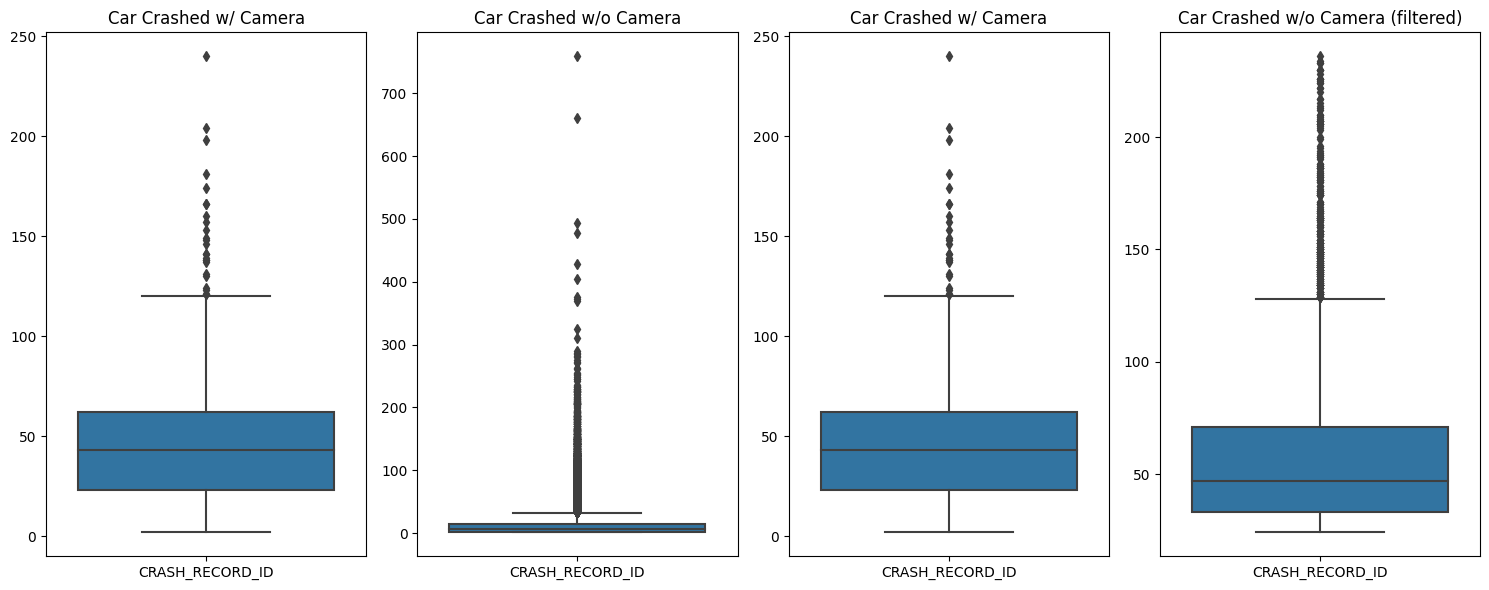

In [15]:
fig, axes = plt.subplots(1, 4, figsize = (15, 6))

sns.boxplot(ax = axes[0], data = camera_crash_count).set_title('Car Crashed w/ Camera')
sns.boxplot(ax = axes[1], data = no_camera_crash_count).set_title('Car Crashed w/o Camera') 
sns.boxplot(ax = axes[2], data = camera_crash_count).set_title('Car Crashed w/ Camera')
sns.boxplot(ax = axes[3], data = filter_no_camera_crash_count).set_title('Car Crashed w/o Camera (filtered)')

# Remove x-axis labels
for ax in axes.flat:
    ax.set(xlabel='')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
#Since there are more streets without speed cameras than with speed cameras, 
#the number of crashes in areas without speed cameras is skewed higher.
#Took 100 samples (n=323) of streets without speed cameras and averaging the results to compare against streets with speed cameras 

start_date = crash['CRASH_DATE_MONTH'].min()
end_date = crash['CRASH_DATE_MONTH'].max()

current_date = start_date
date_list = []

while current_date <= end_date:
    date_list.append(current_date)
    if current_date.month == 12:
        current_date = current_date.replace(year=current_date.year + 1, month=1, day=1)
    else:
        current_date = current_date.replace(month=current_date.month + 1, day=1)

rng = np.random.default_rng(100)
numbers = rng.choice(1000, size=100, replace=False)
no_camera_set = pd.DataFrame({"CRASH_DATE_MONTH":date_list})
no_camera_crash_filtered = no_camera_crash[no_camera_crash['FULL_ADDR'].isin(filter_no_camera_crash_count.index)]

for i in numbers:
    np.random.seed(i)
    sample = np.random.choice(no_camera_crash_filtered['FULL_ADDR'].unique(),323)
    no_camera_sample = no_camera_crash_filtered[no_camera_crash_filtered['FULL_ADDR'].isin(sample)]
    no_camera_sample_group = no_camera_sample[['CRASH_DATE_MONTH','CRASH_RECORD_ID']].groupby(by='CRASH_DATE_MONTH').count()
    no_camera_sample_group.rename(columns= {"CRASH_RECORD_ID":"seed"+str(i)},inplace=True)
    no_camera_set = no_camera_set.merge(no_camera_sample_group, how="left", on='CRASH_DATE_MONTH')

In [17]:
#Group by month truncated date and sum number of occurences
crash_group = crash[['CRASH_DATE_MONTH','CRASH_RECORD_ID']].groupby(by='CRASH_DATE_MONTH').count()
violation_group = violations[['VIOLATION DATE TRUNC','VIOLATIONS']].groupby(by='VIOLATION DATE TRUNC').sum()
camera_crash_group = camera_crash[['CRASH_DATE_MONTH','CRASH_RECORD_ID']].groupby(by='CRASH_DATE_MONTH').count()
no_camera_crash_group = pd.DataFrame({"CRASH_DATE_MONTH":date_list,"CRASH_COUNT":no_camera_set.iloc[:,1:].mean(axis=1)})
no_camera_crash_group.set_index('CRASH_DATE_MONTH', inplace=True)

In [18]:
#rename column to reflect number of serious crashes in a month
crash_group.rename(columns={"CRASH_RECORD_ID":"CRASH_COUNT"},inplace=True)
camera_crash_group.rename(columns={"CRASH_RECORD_ID":"CRASH_COUNT"},inplace=True)
no_camera_crash_group.rename(columns={"CRASH_RECORD_ID":"CRASH_COUNT"},inplace=True)

### Data Exploration

In [19]:
avg_violations_prepolicy = violation_group[violation_group.index<datetime(2021,3,1).date()].mean().iloc[0]
first_mo_violations_postpolicy = violation_group[violation_group.index==datetime(2021,3,1).date()].iloc[0].iloc[0]

In [20]:
formatted_result = (first_mo_violations_postpolicy - avg_violations_prepolicy) * 35
formatted_string = f'{formatted_result:,.0f}'
print("The number of monthly violations jumped from an average of",round(avg_violations_prepolicy,0),"to",first_mo_violations_postpolicy, "in the first month the policy went into effect")
print("This resulted in an additional",formatted_string,"dollars generated in only the first month")

The number of monthly violations jumped from an average of 72297.0 to 326083 in the first month the policy went into effect
This resulted in an additional 8,882,519 dollars generated in only the first month


Text(0.5, 1.0, 'Chicago Speed Camera Violations Trend')

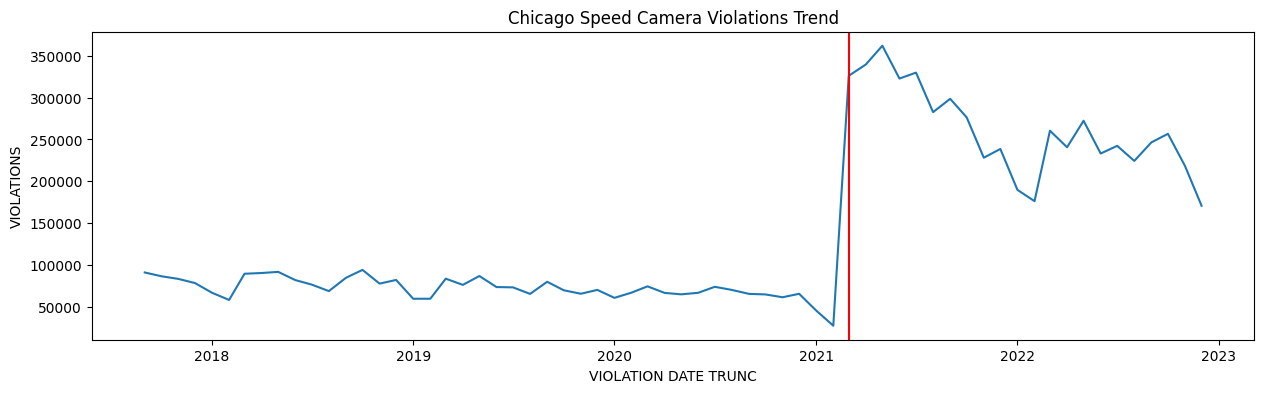

In [21]:
fig, ax = plt.subplots(figsize = (15, 4))
sns.lineplot(x=violation_group.index, y=violation_group['VIOLATIONS'], ax=ax)
plt.axvline(datetime(2021, 3, 1), color='r')
ax.set_title('Chicago Speed Camera Violations Trend')

Text(0.5, 1.0, 'Chicago Car Crash Trend')

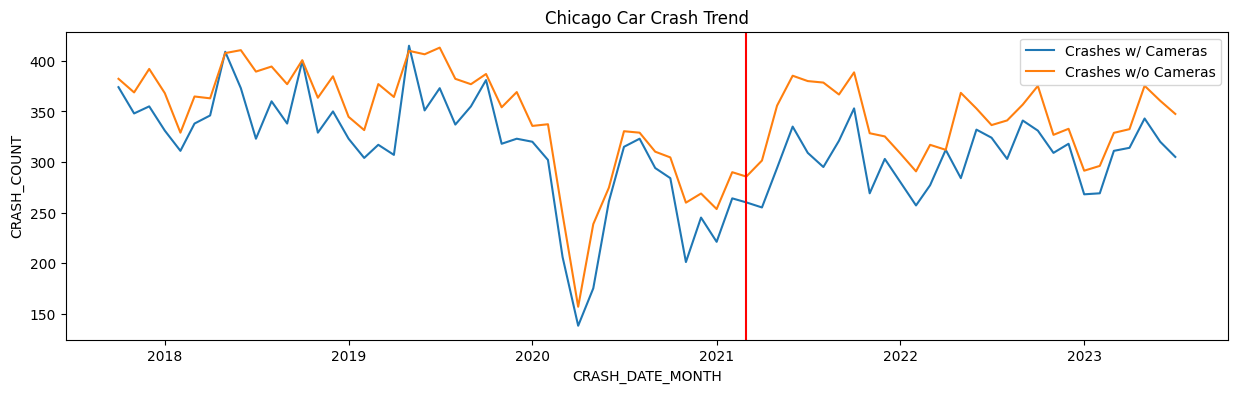

In [22]:
fig, ax = plt.subplots(figsize = (15, 4))

sns.lineplot(x=camera_crash_group.index, y=camera_crash_group['CRASH_COUNT'], ax=ax, label='Crashes w/ Cameras')
sns.lineplot(x=no_camera_crash_group.index, y=no_camera_crash_group['CRASH_COUNT'], ax=ax, label='Crashes w/o Cameras')
plt.axvline(datetime(2021, 3, 1), color='r')
ax.set_title('Chicago Car Crash Trend')

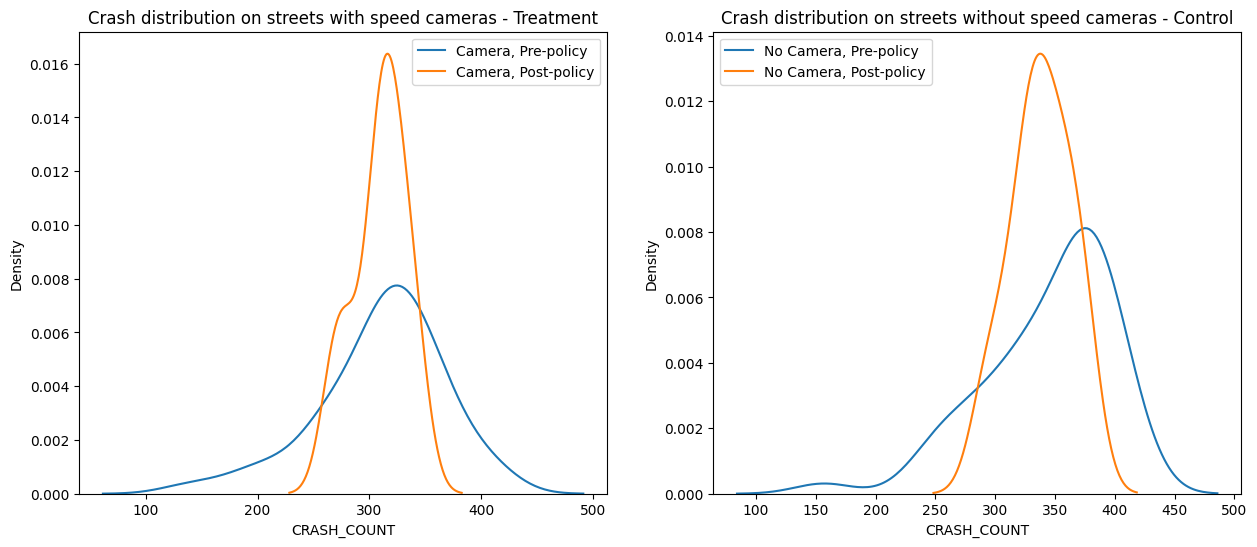

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
sns.kdeplot(ax = axes[0], data = camera_crash_group[camera_crash_group.index<datetime(2022,3,1).date()]['CRASH_COUNT'], label='Camera, Pre-policy')
sns.kdeplot(ax = axes[0], data= camera_crash_group[camera_crash_group.index>=datetime(2022,3,1).date()]['CRASH_COUNT'], label='Camera, Post-policy')

axes[0].set_title('Crash distribution on streets with speed cameras - Treatment')
axes[0].legend()

sns.kdeplot(ax = axes[1], data = no_camera_crash_group[no_camera_crash_group.index<datetime(2022,3,1).date()]['CRASH_COUNT'], label='No Camera, Pre-policy')
sns.kdeplot(ax = axes[1], data= no_camera_crash_group[no_camera_crash_group.index>=datetime(2022,3,1).date()]['CRASH_COUNT'], label='No Camera, Post-policy')

axes[1].set_title('Crash distribution on streets without speed cameras - Control')
axes[1].legend()

### Analysis

In [24]:
# g=0 is the number of crashes on streets without a speed camera
# g=1 is the number of crashes on streets with a speed camera
camera_crash_group['g'] = 1
no_camera_crash_group['g'] = 0

# t=0 is before the policy was implemented
# t=1 is after the policy was implemented
camera_crash_group['t'] = 0
no_camera_crash_group['t'] = 0
camera_crash_group.loc[camera_crash_group[camera_crash_group.index>datetime(2021,3,1).date()].index,'t'] = 1
no_camera_crash_group.loc[no_camera_crash_group[no_camera_crash_group.index>datetime(2021,3,1).date()].index,'t'] = 1

#Data for regression
total_crash = pd.concat([camera_crash_group,no_camera_crash_group])

# create the interaction term
total_crash['gt'] = total_crash.g * total_crash.t


In [25]:
# regression via sklearn
lr = LinearRegression()

X = total_crash[['g', 't', 'gt']]
y = total_crash.CRASH_COUNT

lr.fit(X, y)
lr.coef_  # the coefficient for gt is the DID, which is -255

array([-29.45309524,  -2.23619048,  -7.28761905])

In [26]:

ols = ols('CRASH_COUNT ~ g + t + gt', data=total_crash).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:            CRASH_COUNT   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     5.229
Date:                Sun, 20 Aug 2023   Prob (F-statistic):            0.00190
Time:                        15:40:06   Log-Likelihood:                -742.61
No. Observations:                 140   AIC:                             1493.
Df Residuals:                     136   BIC:                             1505.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    343.6912      7.622     45.092      0.0

### Conclusion

It appears that having a speed camera ('g') is associated with a decrease in car crashes, but the impact of the legislation ('t') and the interaction term ('gt') are not statistically significant based on their high p-values. The overall model has a limited explanatory power, with a low R-squared value.

In conclusion, it seems that this policy was not an effective saftey strategy, but it did generate a large windfall for the City of Chicago.